<a href="https://colab.research.google.com/github/lazybug19/fake-news-detection/blob/main/fakenews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

# Pre-defined Functions

In [5]:
def precision(actual, predicted):
    # Precision = True pos out of the actual results
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FP = np.count_nonzero(np.logical_and((actual == 0) , (predicted == 1)).astype(int))
    return TP/(TP + FP)

def recall(actual, predicted):
    # Recall = True pos out of the predicted results
    TP = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 1)).astype(int))
    FN = np.count_nonzero(np.logical_and((actual == 1) , (predicted == 0)).astype(int))
    return TP/(TP + FN)

def f_score(actual , predicted):
    P = precision(actual, predicted)
    R = recall(actual, predicted)
    return 2*P*R/(P + R)

def textPreprocess(text):
    text = str(text)
    text = text.lower()
    text = re.sub('\[.*?\]','',text)
    text = re.sub("\\W"," ",text)
    text = re.sub('https?://\S+|www\.\S+','',text)
    text = re.sub('<.*?>+',b'',text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    return text

# Data Preprocessing

In [7]:
dataFrame=pd.read_csv('data.csv')

dataFrame.dropna()
dataFrame.reset_index(inplace=True)
dataFrame = shuffle(dataFrame,random_state=20)

dataFrame.head(10)

,index,URLs,Headline,Body,Label
2992,2992,https://www.reuters.com/article/us-brazil-corr...,Brazil Olympic committee chief resigns amid br...,FILE PHOTO: President of Brazil's Olympic Comm...,1
2476,2476,https://www.reuters.com/article/us-usa-trump-e...,Eminem rebukes 'racist' Donald Trump in awards...,(Reuters) - Rapper Eminem derided U.S. Preside...,1
1515,1515,http://beforeitsnews.com/u-s-politics/2017/09/...,Racist Teacher To Student: 'Go Back Where You ...,Racist Teacher To Student: 'Go Back Where You ...,0
1389,1389,http://www.cnn.com/2017/10/11/us/california-fi...,California fires: At least 23 dead as hundreds...,"(CNN) In some areas in Sonoma County, the wild...",1
1402,1402,http://beforeitsnews.com/u-s-politics/2017/10/...,"After Alleged 'Moron' Remark, Tillerson Stroke...","Vietnam Is in Great Danger, You Must Publish a...",0
2245,2245,http://beforeitsnews.com/u-s-politics/2017/10/...,King Salman’s Favorite Golden Escalator Betray...,A Potato Battery Can Light up a Room for Over ...,0
3247,3247,https://www.nytimes.com/2017/10/07/world/europ...,"Amid Catalan Crisis, Thousands Hold Rallies in...","The vote, which had been declared illegal by t...",1
1615,1615,https://www.activistpost.com/2017/09/false-arr...,35 False Matches and 1 Erroneous Arrest As Pol...,By Nicholas West\nAll things biometric are swe...,0
2312,2312,http://beforeitsnews.com/sports/2017/09/bucs-f...,Bucs Finish Up Homestand on Winning Note 5-3,Bucs Finish Up Homestand on Winning Note 5-3\n...,0
993,993,http://beforeitsnews.com/sports/2017/09/alex-c...,Alex Collins Worth a Start?,Alex Collins Worth a Start?\n% of readers thin...,0


In [8]:
value_counts = dataFrame['Label'].value_counts()
ratio = value_counts.get(1, 0) / value_counts.get(0, 0)
print("\nFake:Real News ratio is", ratio)
dataFrame['Label'].value_counts()


Fake:Real News ratio is 0.8759943846513805


Label
0    2137
1    1872
Name: count, dtype: int64

# Text Analysis

In [11]:
stemmer = PorterStemmer()
textList = []
preprocessedText = dataFrame['Body'].apply(textPreprocess)

for text in preprocessedText:
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords.words('english')]
    text = ' '.join(text)
    textList.append(text)

# Example of the preprocessed text
print(textList[1])

reuter rapper eminem derid u presid donald trump racist reckless leader rap video air tuesday night black entertain televis hip hop award eminem told fan four minut unaccompani vocal must choos whether support presid racism thing fantast eminem rap video tape friday detroit park garag trump previous dismiss accus racism exampl said februari least racist person file photo rapper eminem perform afraid bet award lo angel june reuter mario anzuoni file photo repres white hous immedi respond request comment eminem rap one watch video youtub earli wednesday rap also mention barack obama trump predecessor white hous hillari clinton trump democrat rival last year presidenti elect file photo u rapper eminem perform abu dhabi f grand prix race close concert du arena ya island novemb reuter jumana elheloueh file photo better give obama prop caus got offic kamikaz probabl caus nuclear holocaust eminem rap eminem rebuk trump strong critic nation footbal leagu player kneel nation anthem game gestur 

## TFIDF Text Vectorization and SMOTE Upsampling

In [12]:
X=dataFrame.drop('Label',axis=1)
y=dataFrame['Label']

vector=TfidfVectorizer(max_features=5000,ngram_range=(1,3))
X=vector.fit_transform(textList).toarray()

print(X.shape)

(4009, 5000)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Up-sampling minority classes while avoiding overfitting by generating new synthetic examples close to the minority class in feature space.
smote = SMOTE(sampling_strategy=1, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [15]:
# Post smote up-sampling
value_counts = y_train_resampled.value_counts()
ratio = value_counts.get(1, 0) / value_counts.get(0, 0)
print("\nFake:Real News ratio is", ratio)
y_train_resampled.value_counts()


Fake:Real News ratio is 1.0


Label
0    1509
1    1509
Name: count, dtype: int64

In [16]:
parameters = vector._get_param_names()
print
count = pd.DataFrame(X_train, columns=vector.get_feature_names_out())
count.head()

,aaron,aaron judg,aaron kesel,aaron rodger,ab,abandon,abc,abc news,abe,aberti,...,yorker,young,younger,youth,youtub,zach,zapatista,zealand,zero,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.07461,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.048286,0.503343,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.026363,0.0,0.0,0.0,0.0,0.0


# Training models

## Ensemble Learning - 1

In [ ]:
# Base models
model1 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model2 = GaussianNB()
model3 = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# Max voting ensemble with soft voting
ensemble_model1 = VotingClassifier(
    estimators=[
        ('xgb', model1),
        ('nb', model2),
        ('rf', model3)
    ],
    voting='soft'
)

ensemble_model1.fit(X_train_resampled, y_train_resampled)
y_pred = ensemble_model1.predict(X_test)

Accuracy: 0.98
F-score: 0.98
Precision: 0.97
Recall: 0.99


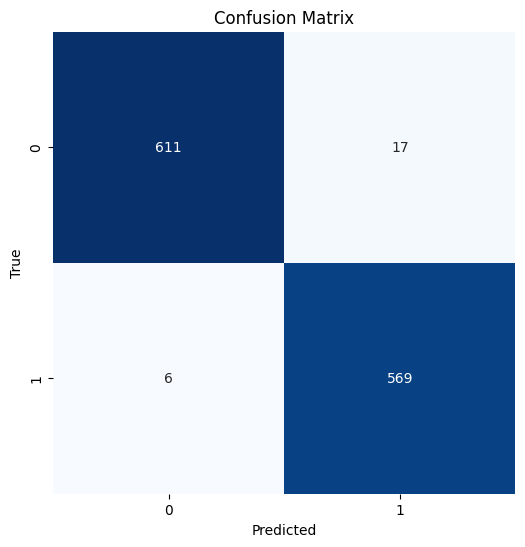

In [ ]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
fscore = f_score(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
conf_m = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

## Ensemble Learning - 2

In [ ]:
# Base models
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=1000, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

In [ ]:
# Max voting ensemble with soft voting
ensemble_model2 = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('lr', lr_model),
        ('gb', gb_model)
    ],
    voting='soft'
)

ensemble_model2.fit(X_train_resampled, y_train_resampled)
y_pred2 = ensemble_model2.predict(X_test)

Accuracy: 0.99
F-score: 0.99
Precision: 0.99
Recall: 0.99


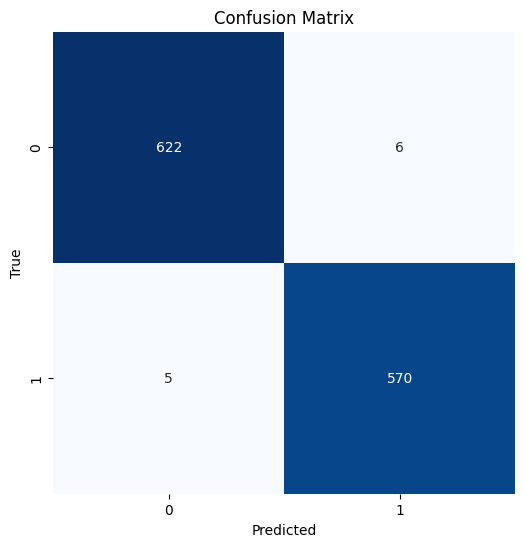

In [ ]:
#Evaluation metrics
accuracy = accuracy_score(y_test, y_pred2)
fscore = f_score(y_test, y_pred2)
prec = precision(y_test, y_pred2)
rec = recall(y_test, y_pred2)
conf_m = confusion_matrix(y_test, y_pred2)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### Better ensemble model with Logistic Regression + Random Forest + Gradient Boosting

# Hyperparameter Tuning for 2nd Model

In [ ]:
# Base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
lr = LogisticRegression(max_iter=1000, random_state=42)

## Bayesian Optimization for RF

In [ ]:
# Function to return negative RMSE
def optimizationRF(n_estimators, max_depth, min_samples_split, max_features):
    model = RandomForestClassifier(n_estimators=int(n_estimators),
                                  max_depth=int(max_depth),
                                  min_samples_split=int(min_samples_split),
                                  max_features=min(max_features, 0.999),
                                  random_state=42)

    return -1.0 * cross_val_score(model, X_train_resampled, y_train_resampled, cv=3, scoring="neg_mean_squared_error").mean()

# Hyperparameters to optimise
param_boundsRF = {
    'n_estimators': (10, 250),
    'max_depth': (1, 50),
    'min_samples_split': (2, 25),
    'max_features': (0.1, 0.999),
}

optimizer = BayesianOptimization(f=optimizationRF, pbounds=param_boundsRF, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.04175   | 19.35     | 0.9547    | 18.84     | 153.7     |
| 2         | 0.03413   | 8.645     | 0.2402    | 3.336     | 217.9     |
| 3         | 0.03645   | 30.45     | 0.7366    | 2.473     | 242.8     |
| 4         | 0.02916   | 41.79     | 0.2909    | 6.182     | 54.02     |
| 5         | 0.03877   | 15.91     | 0.5718    | 11.93     | 79.89     |
| 6         | 0.03115   | 20.09     | 0.4191    | 18.76     | 153.5     |
| 7         | 0.08648   | 3.412     | 0.1166    | 15.81     | 183.7     |
| 8         | 0.08217   | 3.784     | 0.1       | 15.13     | 182.6     |
| 9         | 0.06594   | 5.972     | 0.5506    | 15.86     | 185.4     |
| 10        | 0.217     | 1.135     | 0.4694    | 15.51     | 185.9     |
| 11        | 0.1471    | 2.295     | 0.5123    | 13.45     | 186.4     |
| 12        | 0.224     | 1.414     | 

In [ ]:
# Best hyperparameters
best_params = optimizer.max['params']
print("Best Parameters for RF:", best_params)

# New RandomForestClassifier model with the best hyperparameters
rf_best = RandomForestClassifier(n_estimators=int(best_params['n_estimators']),
                                   max_depth=int(best_params['max_depth']),
                                   min_samples_split=int(best_params['min_samples_split']),
                                   max_features=best_params['max_features'],
                                   random_state=42)

Best Parameters for RF: {'max_depth': 1.629465525941345, 'max_features': 0.16687546655408142, 'min_samples_split': 20.827521435128666, 'n_estimators': 197.67469510524577}


## Bayesian Optimization for GB

In [ ]:
from sklearn.metrics import make_scorer
score = make_scorer(accuracy_score)

def optimizationGB(max_depth, max_features, learning_rate, n_estimators, subsample):
    params_gb = {}
    params_gb['max_depth'] = round(max_depth)
    params_gb['max_features'] = max_features
    params_gb['learning_rate'] = learning_rate
    params_gb['n_estimators'] = round(n_estimators)
    params_gb['subsample'] = subsample

    return (cross_val_score(GradientBoostingClassifier(random_state=42, **params_gb),
                             X_train_resampled, y_train_resampled, scoring=score, cv=5).mean()).mean()

params_gb ={
    'max_depth':(3, 10),
    'max_features':(0.8, 1),
    'learning_rate':(0.01, 1),
    'n_estimators':(80, 150),
    'subsample': (0.8, 1)
}

optimiserGB = BayesianOptimization(optimizationGB, params_gb, random_state=111)
optimiserGB.maximize(init_points=20, n_iter=4)

|   iter    |  target   | learni... | max_depth | max_fe... | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | 0.9771    | 0.616     | 4.183     | 0.8872    | 133.8     | 0.8591    |
| 2         | 0.9728    | 0.1577    | 3.157     | 0.884     | 96.71     | 0.8675    |
| 3         | 0.9722    | 0.9908    | 4.664     | 0.8162    | 126.9     | 0.9242    |
| 4         | 0.9745    | 0.2815    | 6.264     | 0.8237    | 85.18     | 0.9802    |
| 5         | 0.9718    | 0.796     | 8.884     | 0.963     | 149.4     | 0.9155    |
| 6         | 0.9748    | 0.8156    | 5.949     | 0.8055    | 111.8     | 0.8211    |
| 7         | 0.9768    | 0.819     | 7.884     | 0.9131    | 99.2      | 0.9997    |
| 8         | 0.9728    | 0.1467    | 7.308     | 0.897     | 108.4     | 0.9456    |
| 9         | 0.9765    | 0.3296    | 5.804     | 0.8638    | 146.3     | 0.9837    |
| 10        | 0.9732    | 0.8157    | 3.239     | 0.98

In [ ]:
# Best hyperparameters
best_params = optimiserGB.max['params']
best_params['max_depth'] = round(best_params['max_depth'])
best_params['n_estimators'] = round(best_params['n_estimators'])
print("Best Parameters for GB:", best_params)

# New GradientBoostingClassifier model with the best hyperparameters
gb_best = GradientBoostingClassifier(n_estimators=int(best_params['n_estimators']),
                                max_depth=int(best_params['max_depth']),
                                subsample=best_params['subsample'],
                                max_features=best_params['max_depth'],
                                learning_rate=best_params['learning_rate'],
                                random_state=42)

Best Parameters for GB: {'learning_rate': 0.494927115019697, 'max_depth': 7, 'max_features': 0.833799281707321, 'n_estimators': 143, 'subsample': 0.9337483086427925}


## Bayesian Optimization for LR

In [ ]:
# Function to return negative RMSE
def optimizationLR(C, penalty, class_weight):
    penalty = 'l1' if penalty < 0.5 else 'l2'
    class_weight = 'balanced' if class_weight >= 0.5 else None
    model = LogisticRegression(C=C,
                            penalty=penalty,
                            class_weight=class_weight,
                            solver='liblinear',
                            random_state=42)

    return cross_val_score(model, X_train_resampled, y_train_resampled, cv=3, scoring="neg_mean_squared_error").mean()

# Hyperparameters to optimise
param_boundsLR = {
      'C': (0.001, 100),
      'penalty': (0, 1),
      'class_weight': (0, 1)
}
optimizer = BayesianOptimization(f=optimizationLR, pbounds=param_boundsLR, random_state=42)
optimizer.maximize(init_points=5, n_iter=15)

|   iter    |  target   |     C     | class_... |  penalty  |
-------------------------------------------------------------
| 1         | -0.02253  | 37.45     | 0.9507    | 0.732     |
| 2         | -0.02618  | 59.87     | 0.156     | 0.156     |
| 3         | -0.02253  | 5.809     | 0.8662    | 0.6011    |
| 4         | -0.02253  | 70.81     | 0.02058   | 0.9699    |
| 5         | -0.02551  | 83.24     | 0.2123    | 0.1818    |
| 6         | -0.02253  | 70.76     | 0.04546   | 0.8386    |
| 7         | -0.0222   | 29.2      | 0.9924    | 0.737     |
| 8         | -0.02054  | 18.91     | 0.9771    | 0.5203    |
| 9         | -0.02154  | 13.78     | 0.02143   | 0.8402    |
| 10        | -0.02253  | 100.0     | 1.0       | 1.0       |
| 11        | -0.02717  | 22.89     | 0.0       | 0.0       |
| 12        | -0.02154  | 16.81     | 0.8305    | 0.7695    |
| 13        | -0.02121  | 10.74     | 0.8117    | 0.5495    |
| 14        | -0.0222   | 32.96     | 0.01429   | 0.955     |
| 15    

In [ ]:
# Best hyperparameters
best_params = optimizer.max['params']
best_params['class_weight'] = 'balanced' if best_params['class_weight'] >= 0.5 else None
best_params['penalty'] = 'l1' if best_params['penalty'] < 0.5 else 'l2'
print("Best Parameters for LG:", best_params)

# New LogisticRegression model with the best hyperparameters
lr_best = LogisticRegression(C=best_params['C'],
                             penalty=best_params['penalty'],
                             class_weight=best_params['class_weight'],
                             solver='liblinear',
                             random_state=42)

Best Parameters for LG: {'C': 18.90777121832313, 'class_weight': 'balanced', 'penalty': 'l2'}


## Optimised ensemble model

In [ ]:
# Max voting ensemble with soft voting
optimisedModel = VotingClassifier(
    estimators=[
        ('rf', rf_best),
        ('lr', lr_best),
        ('gb', gb_best)
    ],
    voting='soft'
)

optimisedModel.fit(X_train_resampled, y_train_resampled)
y_pred = optimisedModel.predict(X_test)

Accuracy: 0.99
F-score: 0.99
Precision: 0.98
Recall: 0.99


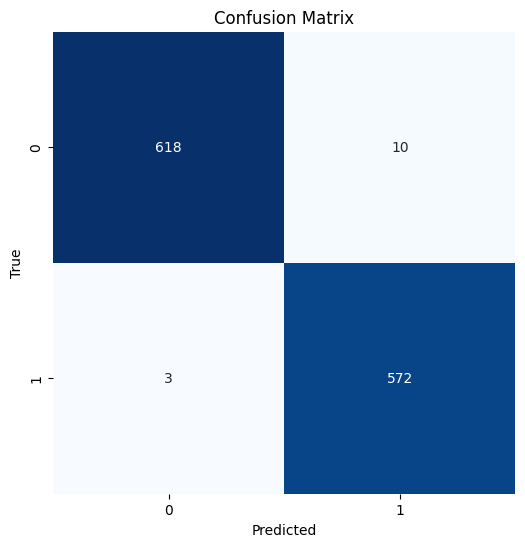

In [ ]:
#Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
fscore = f_score(y_test, y_pred)
prec = precision(y_test, y_pred)
rec = recall(y_test, y_pred)
conf_m = confusion_matrix(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'F-score: {fscore:.2f}')
print(f'Precision: {prec:.2f}')
print(f'Recall: {rec:.2f}')

plt.figure(figsize=(6, 6))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", cbar=False, square=True)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()